# Балансировка классов в задачах классификации: сравнение методов (undersampling, oversampling, SMOTE)
## 1. Введение
В задачах бинарной или многоклассовой классификации часто возникает проблема дисбаланса классов — когда один класс (обычно называемый «миноритарным») представлен значительно меньшим количеством примеров, чем другой («мажоритарный»). Это приводит к тому, что модели машинного обучения склонны игнорировать миноритарный класс, максимизируя общую точность за счёт низкой чувствительности (recall).

Цель данной статьи — сравнить три популярных подхода к решению проблемы дисбаланса:

- Undersampling (уменьшение мажоритарного класса),
- Oversampling (увеличение миноритарного класса путём дублирования),
- SMOTE (синтетическая генерация примеров миноритарного класса).

Для сравнения будет использован реальный датасет с выраженным дисбалансом, и оценка эффективности методов будет проведена по метрикам, адекватным для несбалансированных данных.
## 2. Описание датасета
Датасет **Machine Predictive Maintenance Classification** моделирует ситуацию из промышленного производства или умного завода, где оборудование (например, станки, двигатели, роботизированные манипуляторы) работает непрерывно и генерирует данные о своём состоянии.

Основная цель — предиктивное (прогнозирующее) техническое обслуживание (Predictive Maintenance):

«Можно ли заранее предсказать, какой именно тип отказа произойдёт с машиной, чтобы вовремя остановить её, заменить деталь или отрегулировать параметры — и избежать простоев, аварий или брака?» 

В отличие от реактивного обслуживания (чиним, когда сломалось), планового обслуживания (меняем детали по графику, даже если они ещё работают), предиктивное обслуживание экономит деньги, повышает безопасность и эффективность.

**Признаки:**
1. UDI (числовой) - технический ID строки;
2. Product ID (строка) - уникальный ID продукта;
3. Type (категориальная) - тип оборудования/продукта (L, M, H — возможно, означает Low/Medium/High качество);
4. Air temperature [K] (числовой) - температура воздуха на входе (в Кельвинах);
5. Process temperature [K] (числовой) - температура в процессе обработки;
6. Rotational speed [rpm] (числовой) - скорость вращения (оборотов в минуту);
7. Torque [Nm] (числовой) - крутящий момент (ньютон-метры);
8. Tool wear [min] (числовой) - время износа инструмента (в минутах).

**Целевые переменные:**
1. Target (бинарный) - отказ оборудования (1), нет отказа (0);
2. FailureType (категориальная) - тип отказа оборудования (или его отсутствие).

**Классы целевой переменной:**
1. No Failure - отказа нет (количество: 9652)
2. Heat Dissipation Failure - отказ отвода тепла или перегрев (количество: 112)
3. Power Failure - сбой питания (количество: 95)
4. Overstrain Failure - механическая перегрузка (количество: 78)
5. Tool Wear Failure - отказ из-за износа инструмента (количество: 45)
6. Random Failures - случайные отказы (количество: 18)

Это крайне несбалансированный многоклассовый датасет — идеален для исследования методов балансировки.

**Подготовка данных:**
1. Удалим признаки "UDI", "Product ID", "Type", они нам не понадобятся
2. 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from imblearn.over_sampling import SMOTE

df = pd.read_csv('predictive_maintenance.csv')
df = df.drop(columns=['UDI', 'Product ID', 'Target'])

df = df[df['Failure Type'] != 'Random Failures']
df = df.reset_index(drop=True)

df = pd.get_dummies(df, columns=['Type'], prefix='Type')
for col in ['Type_H', 'Type_L', 'Type_M']:
    if col in df.columns:
        df[col] = df[col].astype(int)

le = LabelEncoder()
y = le.fit_transform(df['Failure Type'])
X = df.drop('Failure Type', axis=1)

class_distribution = df['Failure Type'].value_counts(normalize=True) * 100
print("Распределение классов (в %):")
print(class_distribution.round(2))

X.head()

Распределение классов (в %):
Failure Type
No Failure                  96.69
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Name: proportion, dtype: float64


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,1,0
2,298.1,308.5,1498,49.4,5,0,1,0
3,298.2,308.6,1433,39.5,7,0,1,0
4,298.2,308.7,1408,40.0,9,0,1,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

## Без балансировки

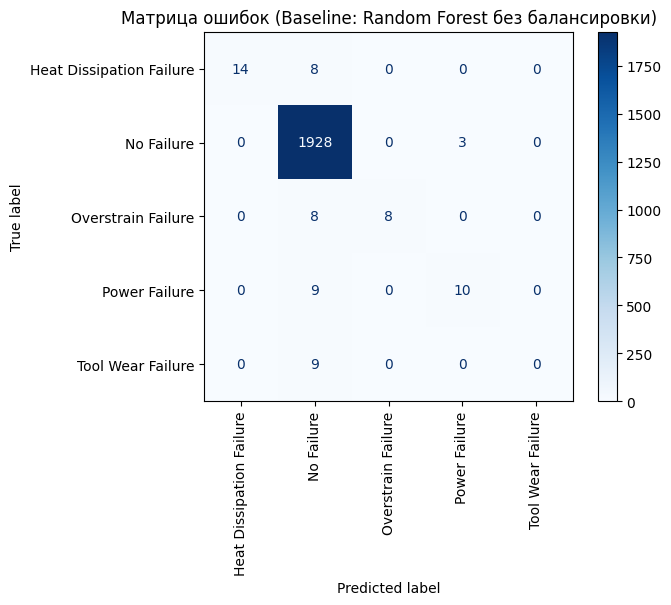

Общая точность (Accuracy): 0.9815
Macro-Precision:          0.7504
Macro-Recall:             0.5322
Macro-F1:                 0.6120
Weighted-F1:              0.9776
Cohen's Kappa:            0.6281

Подробный отчёт по каждому классу:
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.64      0.78        22
              No Failure       0.98      1.00      0.99      1931
      Overstrain Failure       1.00      0.50      0.67        16
           Power Failure       0.77      0.53      0.62        19
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.98      1997
               macro avg       0.75      0.53      0.61      1997
            weighted avg       0.98      0.98      0.98      1997



c:\Users\Elizaveta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Elizaveta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Elizaveta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [10]:
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (Baseline: Random Forest без балансировки)')
plt.show()

# Общая точность (accuracy) — для справки, но НЕ основная метрика!
acc = accuracy_score(y_test, y_pred)

# Macro-усреднённые метрики — важны при дисбалансе!
macro_prec = precision_score(y_test, y_pred, average='macro')
macro_rec = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Weighted-усреднённые метрики — учитывают дисбаланс
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Cohen's Kappa — учитывает случайное угадывание
kappa = cohen_kappa_score(y_test, y_pred)

# Вывод
print(f"Общая точность (Accuracy): {acc:.4f}")
print(f"Macro-Precision:          {macro_prec:.4f}")
print(f"Macro-Recall:             {macro_rec:.4f}")
print(f"Macro-F1:                 {macro_f1:.4f}")
print(f"Weighted-F1:              {weighted_f1:.4f}")
print(f"Cohen's Kappa:            {kappa:.4f}")
print("\n" + "="*60)
print("Подробный отчёт по каждому классу:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Модель отлично распознаёт No Failure:
- 1928 верных предсказаний → почти все примеры этого класса угаданы.
- только 3 ошибки — предсказано как Power Failure.

Редкие классы плохо предсказываются:
- Heat Dissipation Failure (14 верно, 8 ошибочно)
- Overstrain Failure (8 верно, 8 ошибочно)
- Power Failure (10 верно, 9 ошибочно)
- Tool Wear Failure (0 верно, 9 ошибочно)

Это главная проблема дисбаланса: модель игнорирует редкие классы, потому что ошибка по ним не сильно влияет на общую точность. Без балансировки Random Forest практически не способен распознавать миноритарные классы — он "выучивает" только мажоритарный класс (No Failure).
### SMOTE

Размер обучающей выборки ДО SMOTE: (7985, 8)
Распределение классов ДО SMOTE:
0      90
1    7721
2      62
3      76
4      36
Name: count, dtype: int64

Размер обучающей выборки ПОСЛЕ SMOTE: (38605, 8)
Распределение классов ПОСЛЕ SMOTE:
0    7721
1    7721
2    7721
3    7721
4    7721
Name: count, dtype: int64

МЕТРИКИ ПОСЛЕ ПРИМЕНЕНИЯ SMOTE
Accuracy:    0.9755
Macro-F1:    0.6878
Macro-Recall:0.7258

Подробный отчёт:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.70      0.86      0.78        22
              No Failure       0.99      0.98      0.99      1931
      Overstrain Failure       0.74      0.88      0.80        16
           Power Failure       0.76      0.68      0.72        19
       Tool Wear Failure       0.12      0.22      0.15         9

                accuracy                           0.98      1997
               macro avg       0.66      0.73      0.69      1997
            weighted avg       0.98      0.98 

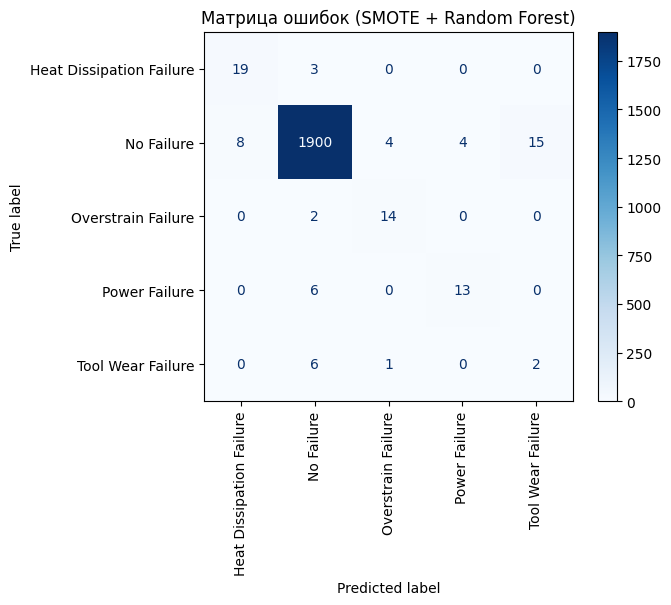

In [11]:
print("Размер обучающей выборки ДО SMOTE:", X_train.shape)
print("Распределение классов ДО SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nРазмер обучающей выборки ПОСЛЕ SMOTE:", X_train_smote.shape)
print("Распределение классов ПОСЛЕ SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())

# ========== 4. Обучение модели на сбалансированных данных ==========
model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# ========== 5. Предсказание на ИСХОДНОЙ тестовой выборке ==========
y_pred_smote = model_smote.predict(X_test)

# ========== 6. Метрики ==========
print("\n" + "="*60)
print("МЕТРИКИ ПОСЛЕ ПРИМЕНЕНИЯ SMOTE")
print("="*60)

acc_smote = accuracy_score(y_test, y_pred_smote)
macro_f1_smote = f1_score(y_test, y_pred_smote, average='macro')
macro_rec_smote = recall_score(y_test, y_pred_smote, average='macro')

print(f"Accuracy:    {acc_smote:.4f}")
print(f"Macro-F1:    {macro_f1_smote:.4f}")
print(f"Macro-Recall:{macro_rec_smote:.4f}")

print("\nПодробный отчёт:")
print(classification_report(y_test, y_pred_smote, target_names=le.classes_, zero_division=0))

# ========== 7. Матрица ошибок ==========
cm_smote = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Матрица ошибок (SMOTE + Random Forest)')
plt.show()

1. Heat Dissipation Failure (19 верно, 3 ошибки)
2. No Failure (1900 верно, 35 ошибок)
3. Overstrain Failure (14 верно, 2 ошибки)
4. Power Failure (13 верно, 6 ошибок)
5. Tool Wear Failure (2 верно, 7 ошибок)
## Undersampling